# Fit Demo - Simulated Data with `qsosed` Model
---------

Simulate and fit an AGN with the `qsosed` model.

## Imports

In [2]:
import numpy as np
import astropy.units as u
from astropy.table import Table
from astropy.io import ascii
from astropy.cosmology import FlatLambdaCDM
from corner import corner
import matplotlib.pyplot as plt
plt.style.use('ebm-dejavu')
%matplotlib inline

from lightning import Lightning
from lightning.priors import UniformPrior

## Initialize Lightning

In [4]:
filter_labels = ['XRAY_2.0_7.0_keV', 'XRAY_1.2_2.0_keV', 'XRAY_0.5_1.2_keV',
                     'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z',
                     'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3', 'IRAC_CH4',
                     'PACS_green', 'PACS_red']

redshift = 1.0
lum_dist = None

arf = Table.read('../photometry/cdfn_near_aimpoint.arf')

l = Lightning(filter_labels,
             redshift=redshift,
             #lum_dist=lum_dist,
             flux_obs=None,
             flux_obs_unc=None,
             wave_grid=(1e-1, 1e3, 1200),
             SFH_type='Piecewise-Constant',
             atten_type='Calzetti',
             dust_emission=True,
             agn_emission=True,
             xray_stellar_emission='Stellar-Plaw',
             xray_agn_emission='QSOSED',
             xray_absorption='tbabs',
             galactic_NH=0.9, # times 10^20 cm-2
             xray_wave_grid=(1e-4, 1e-1, 200),
             xray_arf=arf,
             xray_exposure=3e4, # 30 ks
             xray_mode='counts',
             print_setup_time=True,
             model_unc=0.10
             )

0.019 s elapsed in _get_filters
0.001 s elapsed in _get_wave_obs
0.459 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
0.375 s elapsed in dust emission model setup
0.038 s elapsed in agn emission model setup
0.089 s elapsed in X-ray model setup
0.982 s elapsed total


/Users/Erik/Research/code/plightning/lightning/get_filters.py:143: RuntimeWarning: divide by zero encountered in divide
  transm_norm_interp = transm_interp / trapz(transm_interp, wave_grid)
/Users/Erik/Research/code/plightning/lightning/get_filters.py:143: RuntimeWarning: invalid value encountered in divide
  transm_norm_interp = transm_interp / trapz(transm_interp, wave_grid)


In [5]:
l.print_params(verbose=True)


Piecewise-Constant
Parameter  Lo  Hi              Description
--------- --- --- ------------------------
    psi_1 0.0 inf SFR in stellar age bin 1
    psi_2 0.0 inf SFR in stellar age bin 2
    psi_3 0.0 inf SFR in stellar age bin 3
    psi_4 0.0 inf SFR in stellar age bin 4
    psi_5 0.0 inf SFR in stellar age bin 5

Calzetti
     Parameter  Lo  Hi                      Description
-------------- --- --- --------------------------------
calz_tauV_diff 0.0 inf Optical depth of the diffuse ISM

DL07-Dust
      Parameter     Lo       Hi                                                             Description
--------------- ------ -------- -----------------------------------------------------------------------
dl07_dust_alpha  -10.0      4.0                  Radiation field intensity distribution power law index
dl07_dust_U_min    0.1     25.0                                       Radiation field minimum intensity
dl07_dust_U_max 1000.0 300000.0                                       Radi

In [7]:
# Recent SFH, relatively unobscured,
# assuming all the X-ray absorption is Galactic.
params = np.array([5,5,1,1,1,
                   0.1,
                   2, 1, 3e5, 0.1, 0.01,
                   11, 0.5, 7,
                   1.8,
                   8, -1.0,
                   100.0])

Lmod, _ = l.get_model_lnu(params)
Lmod_xray, _ = l.get_xray_model_lnu(params)
counts_mod = l.get_xray_model_counts(params)

# By (weird) construction, the elements of Lmod corresponding to the X-ray filters
# in Lmod are NaN, and the elements of Lmod_xray corresponding to the UV-IR filters
# are NaN.
xray_mask = np.isnan(Lmod)
#Lmod[xray_mask] = Lmod_xray[xray_mask]

snr = 10.0

rng = np.random.default_rng()

Lsim = rng.normal(loc=Lmod, scale=Lmod / snr)
Lsim_unc = Lsim / snr

# A silly step, converting the data to mJy just so lightning can convert back to Lsun Hz-1
# Note that the input units for the X-ray fluxes are also mJy; this is kind of weird since
# X-ray fluxes are typically not presented as monochromatic given the width of the bandpasses
# involved.
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
DL = cosmo.luminosity_distance(redshift)

fsim = (Lsim * u.Lsun / u.Hz / (4 * np.pi * DL**2)).to(u.mJy).value
fsim_unc = (Lsim_unc  * u.Lsun / u.Hz / (4 * np.pi * DL**2)).to(u.mJy).value

# The current setup for X-ray counts is to stick them into the flux array. You can
# imagine that this would be more intuitive if you were reading the data from a file
# rather than constructing it from a simulation
counts_sim = rng.poisson(lam=counts_mod[xray_mask])
fsim[xray_mask] = counts_sim
#fsim_unc[xray_mask] = 1 + np.sqrt(0.75 + counts_sim)
fsim_unc[xray_mask] = counts_sim / snr

# Note the warning generated by this step -- the minimum luminosity distance is probably something
# we ought to change; we'll want to add the option to specify a luminosity distance rather than
# a redshift for very nearby galaxies.
l.flux_obs = fsim
l.flux_unc = fsim_unc

t = Table()
t['filter'] = l.filter_labels
# t['flux_obs'] = l.flux_obs
# t['flux_unc'] = l.flux_unc
t['Lnu_obs'] = l.Lnu_obs
t['Lnu_unc'] = l.Lnu_unc
t['xray_counts'] = l.xray_counts
t['xray_counts_unc'] = l.xray_counts_unc

#ascii.write(t, format='fixed_width_two_line')
#print(counts_sim[xray_mask])
t.show_in_notebook()

/Users/Erik/Research/code/plightning/lightning/xray/stellar.py:221: RuntimeWarning: divide by zero encountered in log10
  np.log10(lnu_obs) + np.log10(self.specresp[None, :]) - np.log10(self.phot_energ[None,:])
/Users/Erik/Research/code/plightning/lightning/xray/agn.py:612: RuntimeWarning: divide by zero encountered in log10
  np.log10(lnu_obs) + np.log10(self.specresp) - np.log10(self.phot_energ)


idx,filter,Lnu_obs,Lnu_unc,xray_counts,xray_counts_unc
0,XRAY_2.0_7.0_keV,nan,0.0,11.0,1.1
1,XRAY_1.2_2.0_keV,nan,0.0,24.0,2.4
2,XRAY_0.5_1.2_keV,nan,0.0,11.0,1.1
3,SDSS_u,2.3887891476540252e-05,2.3887891476540255e-06,nan,0.0
4,SDSS_g,2.273799848878177e-05,2.273799848878177e-06,nan,0.0
5,SDSS_r,2.2526403750376357e-05,2.2526403750376356e-06,nan,0.0
6,SDSS_i,3.600488160626e-05,3.6004881606260005e-06,nan,0.0
7,SDSS_z,3.0348100869940996e-05,3.0348100869940996e-06,nan,0.0
8,IRAC_CH1,8.849530749695478e-05,8.84953074969548e-06,nan,0.0
9,IRAC_CH2,0.0001139897743635131,1.139897743635131e-05,nan,0.0


In [8]:
p = np.array([5,5,1,1,1,
              0.1,
              2, 1, 3e5, 0.1, 0.01,
              11, 0.5, 7,
              1.8,
              8, -1.0,
              100.0])

# Currently the setup is to provide this mask that tells
# lightning which parameters are constant
const_dim = np.array([False, False, False, False, False,
                      False,
                      True, False, True, False, False,
                      True, True, False,
                      True,
                      False, False,
                      False])

var_dim = ~const_dim

priors = [UniformPrior([0, 1e1]), # SFH
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 3]), # tauV
          None, # alpha
          UniformPrior([0.1, 25]), # Umin
          None, # Umax
          UniformPrior([0,1]), # Gamma
          UniformPrior([0.0047, 0.0458]), #qPAH
          None, # log L_AGN -- constant here because we're using the qsosed model.
          None, # cos i
          UniformPrior([3,11]), # tau 9.7
          None, # stellar pop. pho. index
          UniformPrior([6,9]), # SMBH mass
          UniformPrior([-1.5, 0.0]), # log Eddington ratio
          UniformPrior([1, 500]) # NH
          ]

Nwalkers = 64
Nsteps = 20000

# Starting the MCMC in a very small Gaussian ball around the 'true' parameters
p0 = p[None, :] + rng.normal(loc=0, scale=1e-3, size=(Nwalkers, len(p)))
p0[:, const_dim] = p[const_dim]

In [9]:
mcmc = l.fit(p0, method='emcee', Nwalkers=Nwalkers, Nsteps=Nsteps, priors=priors, const_dim=const_dim)

/Users/Erik/Research/code/plightning/lightning/xray/stellar.py:221: RuntimeWarning: divide by zero encountered in log10
  np.log10(lnu_obs) + np.log10(self.specresp[None, :]) - np.log10(self.phot_energ[None,:])
/Users/Erik/Research/code/plightning/lightning/xray/agn.py:612: RuntimeWarning: divide by zero encountered in log10
  np.log10(lnu_obs) + np.log10(self.specresp) - np.log10(self.phot_energ)
  1%|▉                                                                                                                    | 161/20000 [00:17<30:20, 10.90it/s]/Users/Erik/Research/code/plightning/lightning/lightning.py:1436: RuntimeWarning: divide by zero encountered in log
  log_prior[ib_mask] = np.log(np.prod(prior_arr, axis=1))
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [29:31<00:00, 11.29it/s]


In [10]:
print('MCMC mean acceptance fraction: %.3f' % (np.mean(mcmc.acceptance_fraction)))
# chain = mcmc.get_chain(discard=1000, thin=300, flat=True)
# logprob_chain = mcmc.get_log_prob(discard=1000, thin=300, flat=True)

MCMC mean acceptance fraction: 0.186


In [12]:
# Automatically construct chopped/thinned/flattened chains
# based on the autocorrelation times of the chains, and retain the
# last 1000 samples. If we instead got a message
# here that the autocorrelation times were too long, we could:
# - Provide a manual scale for burn-in and thinning
# - Re-run the whole MCMC (expensive)
# - Simply continue the MCMC where it left off by doing mcmc.run_mcmc(None, Nsteps).
chain, logprob_chain, tau_ac = l.get_mcmc_chains(mcmc, discard=2000, thin=500, flat=True)

         The autocorrelation estimate may be unreliable.


In [13]:
# Reassembling the parameter array by including the constant parameters
# since the new plot functions want the whole set.
param_arr = np.zeros((chain.shape[0], l.Nparams))
param_arr[:, const_dim] = p[None, const_dim]
param_arr[:, var_dim] = chain

## SFH Chain Plot

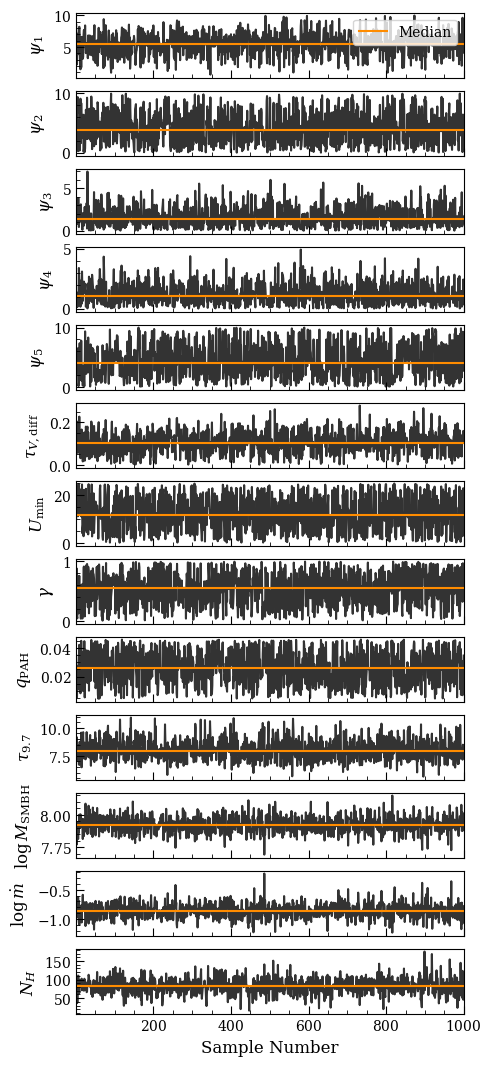

In [14]:
from lightning.plots import chain_plot

fig, axs = chain_plot(l, param_arr, color='k', alpha=0.8)

## Corner Plot

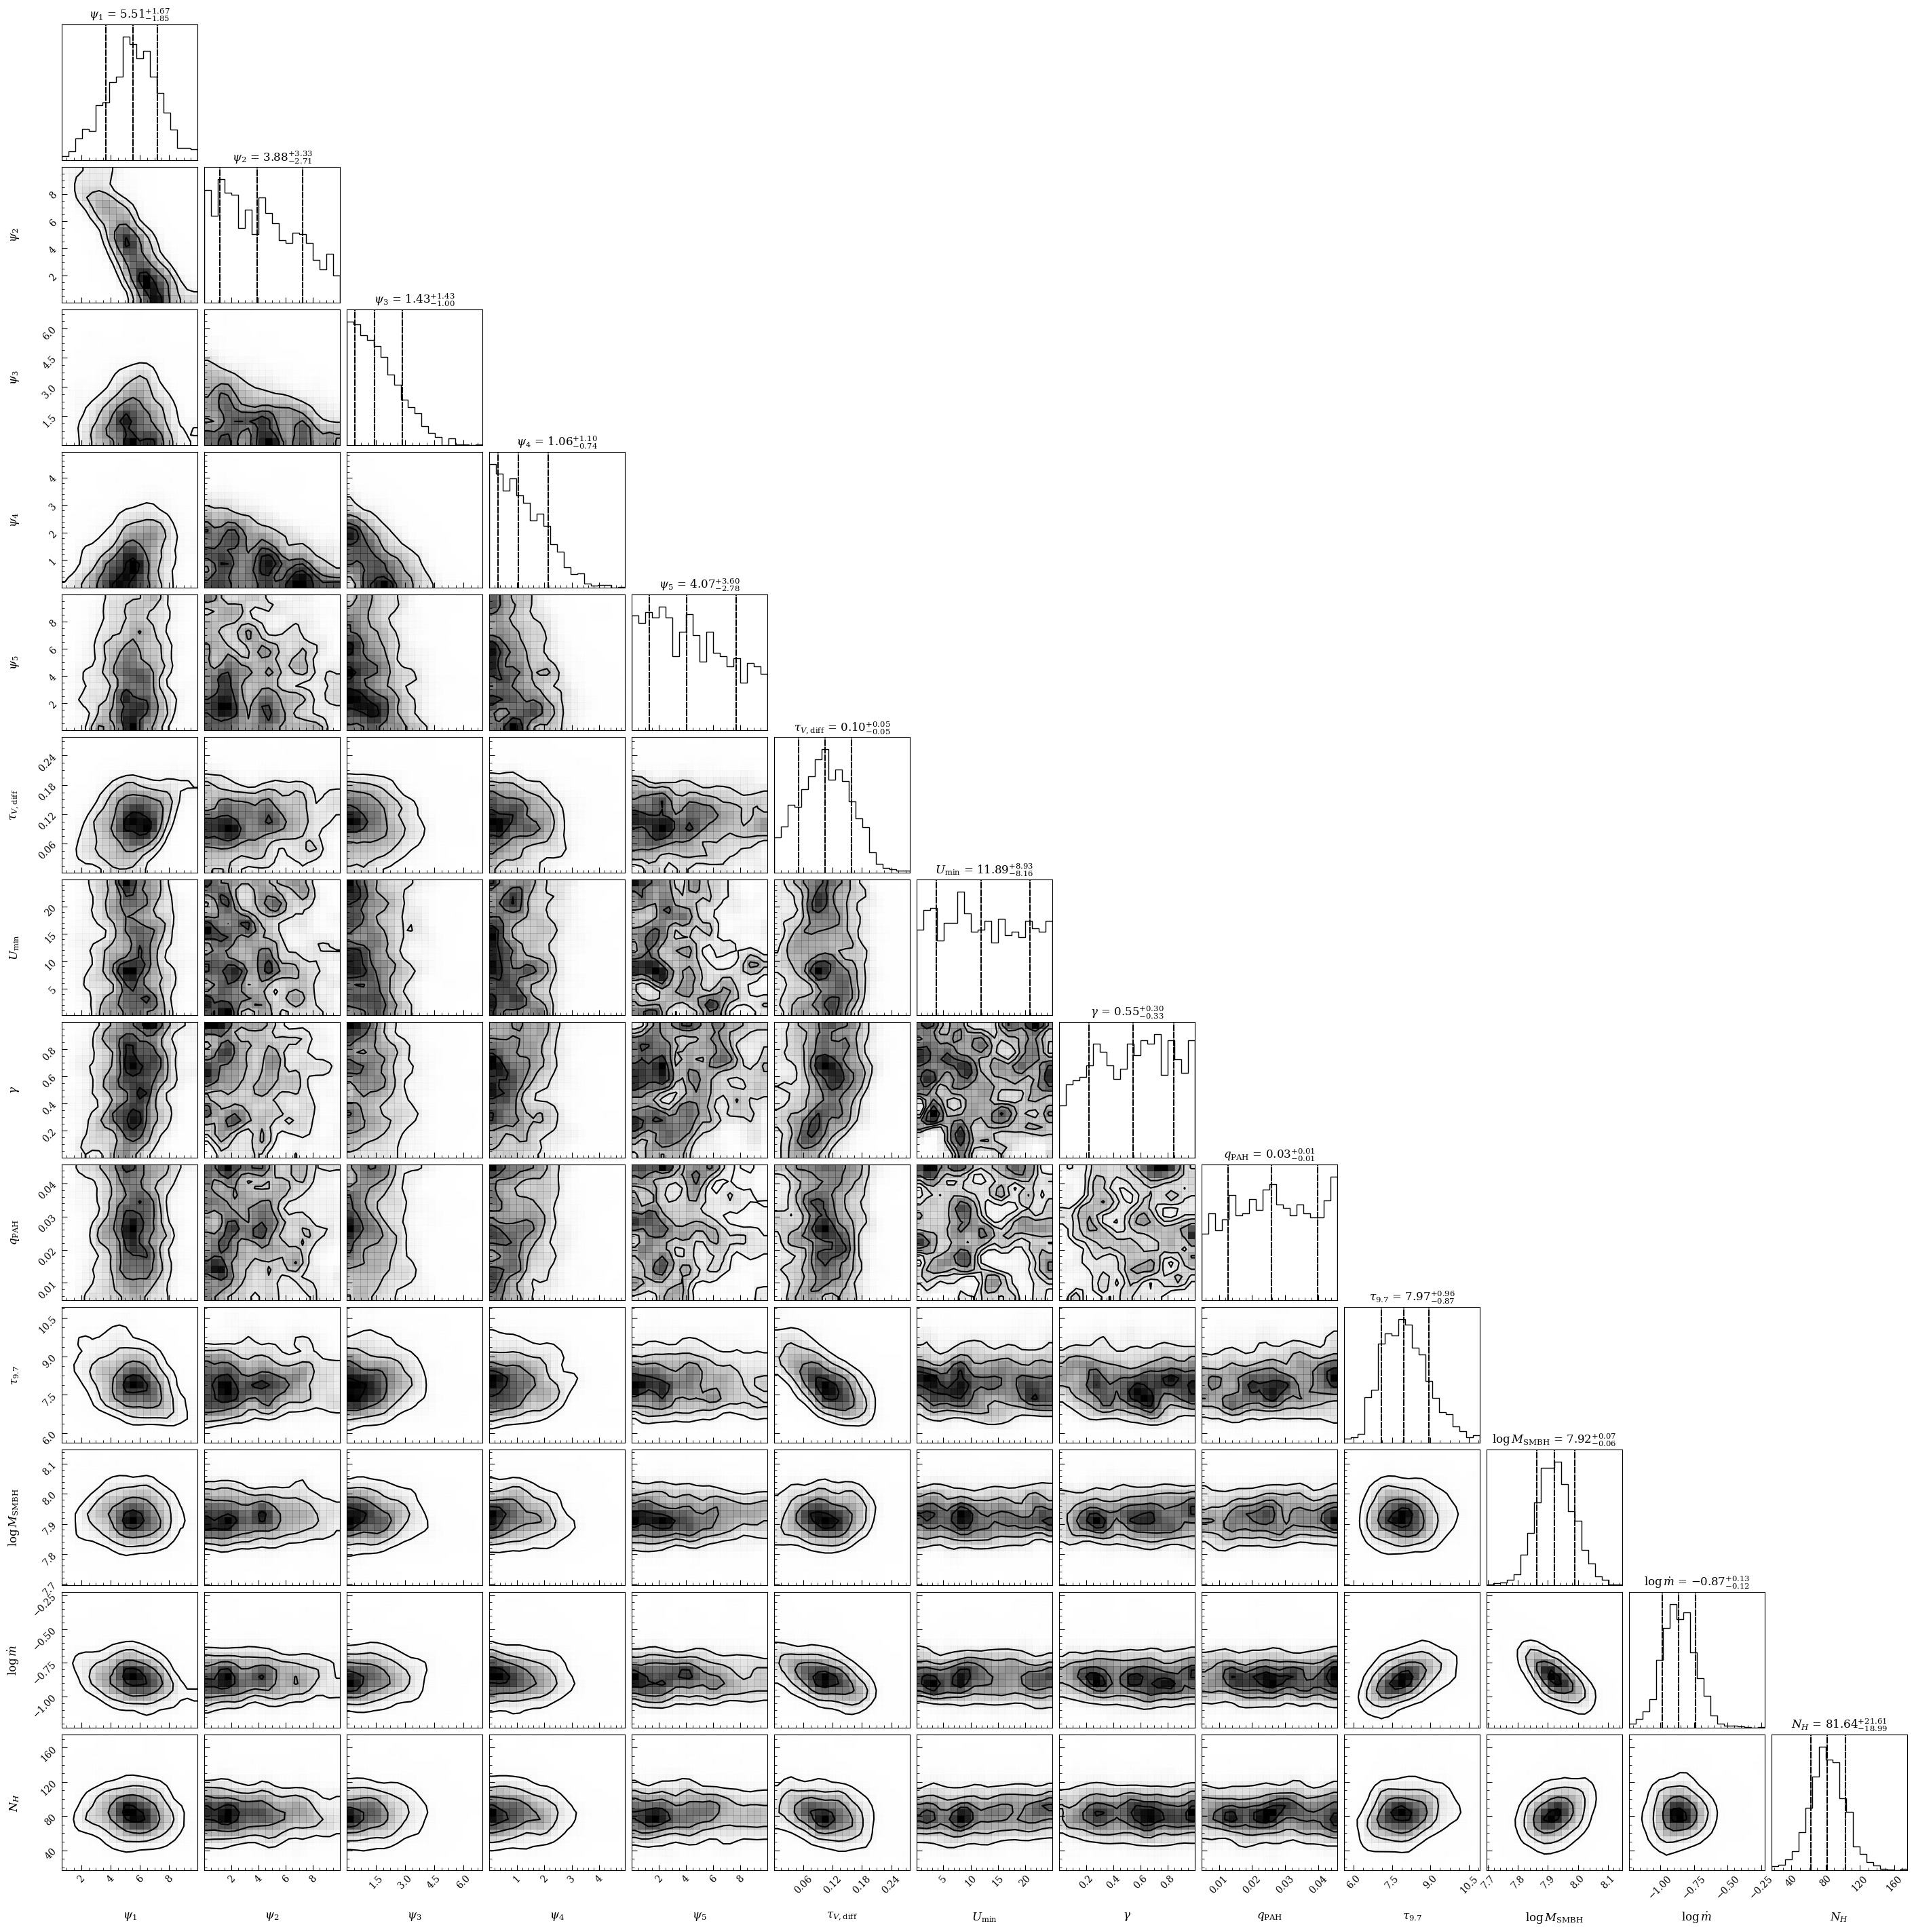

In [15]:
from lightning.plots import corner_plot

fig = corner_plot(l, param_arr, 
                  quantiles=(0.16, 0.50, 0.84),
                  smooth=1,
                  levels=None,
                  show_titles=True)

Clearly some of the dust model parameters are acting as nuisance parameters, contributing to our long autocorrelation times and low acceptance fraction. We've done a decent job constraining the QSOSED parameters, however.

## SED/SFH Plot
I still haven't properly added the X-ray models to the default plotting script, have I

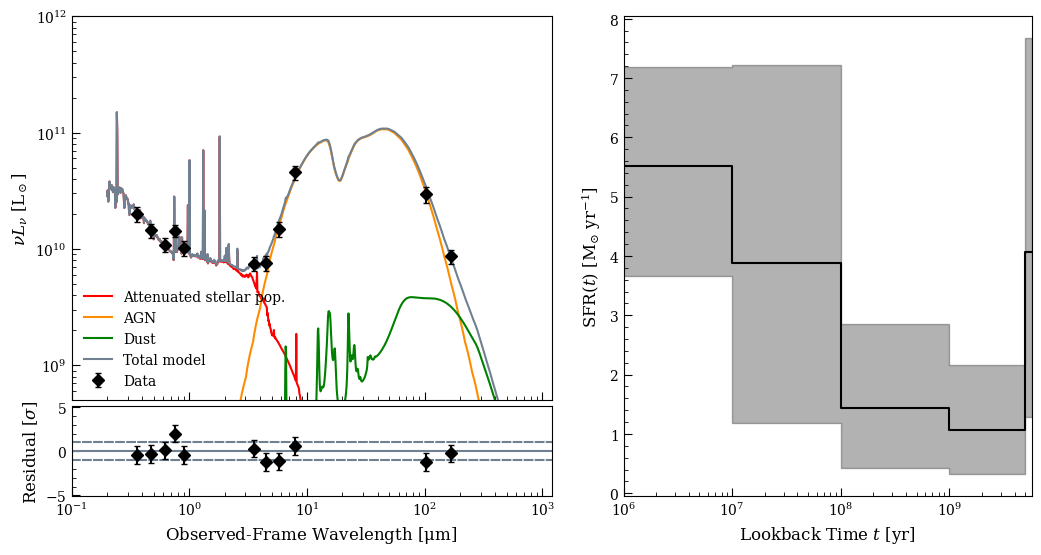

In [18]:
from lightning.plots import sed_plot_bestfit, sed_plot_delchi, sfh_plot

# We can use the builtin plotting functions to make individual figures...
# fig1, ax1 = sed_plot_bestfit(l, param_arr, logprob_chain, plot_components=True)
# fig2, ax2 = sed_plot_delchi(l, param_arr, logprob_chain)
# fig3, ax3 = sfh_plot(l, param_arr)

# Or we can use them to make a complex (hopefully) publication quality 
# figure by laying out our axes and then using the `ax` keyword in each function:
fig4 = plt.figure(figsize=(12,6))
ax41 = fig4.add_axes([0.1, 0.26, 0.4, 0.64])
ax42 = fig4.add_axes([0.1, 0.1, 0.4, 0.15])
ax43 = fig4.add_axes([0.56, 0.1, 0.34, 0.8])

fig4, ax41 = sed_plot_bestfit(l, param_arr, logprob_chain,
                              plot_components=True,
                              ax=ax41,
                              legend_kwargs={'loc': 'lower left', 'frameon': False})

ax41.set_ylim(5e8, 1e12)

ax41.set_xticklabels([])
fig4, ax42 = sed_plot_delchi(l, param_arr, logprob_chain, ax=ax42)
fig4, ax43 = sfh_plot(l, param_arr, ax=ax43)

In [19]:
# Get best-fitting SED
bestfit = np.argmax(logprob_chain)
bestfit_samples = chain[bestfit,:]
bestfit_params = p
bestfit_params[var_dim] = bestfit_samples

lnu_hires_best, lnu_hires_intr_best = l.get_model_lnu_hires(bestfit_params)
lnu_best, lnu_intr_best = l.get_model_lnu(bestfit_params)

lnu_xray_hires_best, lnu_xray_hires_intr_best = l.get_xray_model_lnu_hires(bestfit_params)
lnu_xray_best, lnu_xray_intr_best = l.get_xray_model_lnu(bestfit_params)
counts_xray_best = l.get_xray_model_counts(bestfit_params)
lnu_obs_xray_best = counts_xray_best[xray_mask] / counts_sim * lnu_xray_best[xray_mask]
lnu_unc_xray_best = lnu_obs_xray_best / snr
#lmod_xray = 

lnu_unc_total = np.sqrt(l.Lnu_unc**2 + (l.model_unc * lnu_best)**2)
lnu_xray_unc_total = np.sqrt(l.Lnu_unc**2 + (l.model_unc * lnu_xray_best)**2)

# Get the quantiles of the SFH
sfh_q = np.quantile(chain[:,:5], q=(0.16, 0.5, 0.84), axis=0)

(1000000.0, 13600000000.0)

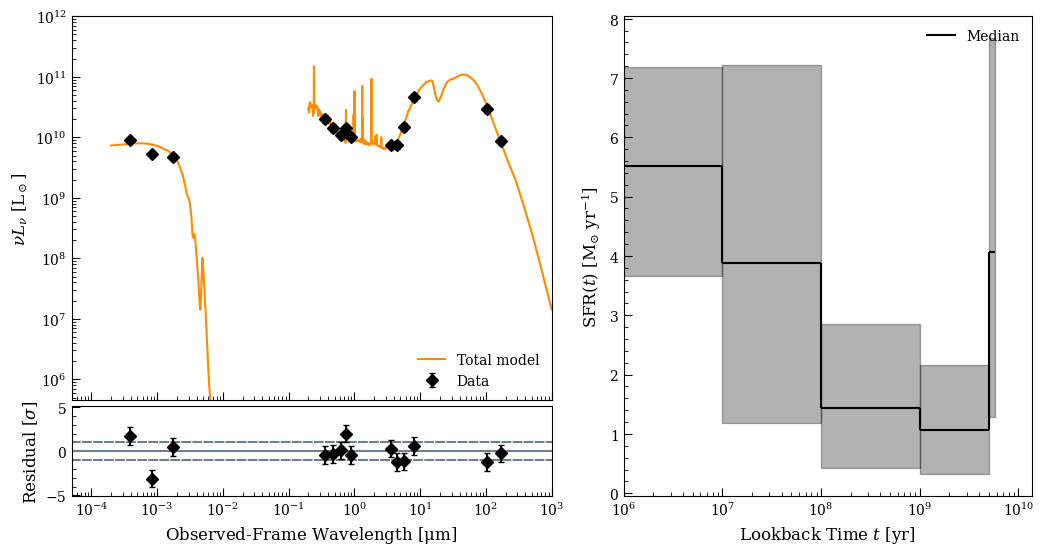

In [20]:
# fig, axs = plt.subplots(1,2, figsize=(12,6))
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_axes([0.1, 0.26, 0.4, 0.64])
ax2 = fig.add_axes([0.1, 0.1, 0.4, 0.15])
ax3 = fig.add_axes([0.56, 0.1, 0.34, 0.8])

# ax1.plot(l.wave_grid_obs, l.nu_grid_obs * lnu_hires_intr_best,
#             color='dodgerblue', label='Intrinsic spectrum')

ax1.plot(l.wave_grid_obs, l.nu_grid_obs * lnu_hires_best,
            color='darkorange', label='Total model')

ax1.errorbar(l.wave_obs, l.nu_obs * l.Lnu_obs, yerr=l.nu_obs * lnu_unc_total,
             marker='D', color='k', markerfacecolor='k', capsize=2, linestyle='',
             label='Data')

# ax1.errorbar(l.wave_obs, l.nu_obs * Lmod, yerr=0,
#              marker='D', color='limegreen', markerfacecolor='limegreen', capsize=2, linestyle='',
#              label='Truth')

# ax1.plot(l.xray_stellar_em.wave_grid_obs,
#          l.xray_stellar_em.nu_grid_obs * lnu_xray_hires_intr_best,
#          color='dodgerblue')
ax1.plot(l.xray_stellar_em.wave_grid_obs,
         l.xray_stellar_em.nu_grid_obs * lnu_xray_hires_best,
         color='darkorange')
ax1.errorbar(l.xray_stellar_em.wave_obs[xray_mask],
             l.xray_stellar_em.nu_obs[xray_mask] * lnu_obs_xray_best,
             yerr=lnu_unc_xray_best,
             marker='D', color='k', markerfacecolor='k', capsize=2, linestyle='')
# ax1.errorbar(l.xray_stellar_em.wave_obs,
#              l.xray_stellar_em.nu_obs * Lmod_xray,
#              yerr=0,
#              marker='D', color='limegreen', markerfacecolor='limegreen', capsize=2, linestyle='')

#ax1.set_xlabel(r'Observed-Frame Wavelength $[\rm \mu m]$')
ax1.set_ylabel(r'$\nu L_{\nu}\ [\rm L_\odot]$')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(5e-5, 1e3)
ax1.set_ylim(0.9 * 5e5, 1e12)
ax1.legend(loc='lower right')
ax1.set_xticklabels([])

delchi = (l.Lnu_obs - lnu_best) / lnu_unc_total

ax2.axhline(0, color='slategray', linestyle='-')
ax2.axhline(-1, color='slategray', linestyle='--')
ax2.axhline(1, color='slategray', linestyle='--')

ax2.errorbar(l.wave_obs, delchi, yerr=(1 + np.zeros_like(delchi)),
             marker='D', color='k', markerfacecolor='k', capsize=2, linestyle='')

#delchi_xray = (l.Lnu_obs - lnu_xray_best) / lnu_xray_unc_total
delchi_xray = (counts_xray_best[xray_mask] - counts_sim) / (counts_sim / snr)

ax2.errorbar(l.xray_stellar_em.wave_obs[xray_mask],
             delchi_xray,
             yerr=(1 + np.zeros_like(delchi_xray)),
             marker='D',
             color='k',
             markerfacecolor='k',
             capsize=2,
             linestyle='')

ax2.set_xscale('log')
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(-5.1,5.1)

ax2.set_xlabel(r'Observed-Frame Wavelength $[\rm \mu m]$')
ax2.set_ylabel(r'Residual $[\sigma]$')

# Making nice step plots remains an annoyance
#print(sfh_q.shape)
for i in np.arange(len(l.ages) - 1):
    ax3.fill_between([l.ages[i], l.ages[i+1]],
                        [sfh_q[0,i], sfh_q[0,i]], 
                        [sfh_q[2,i], sfh_q[2,i]],
                        color='k', alpha=0.3)
    l1 = ax3.hlines(sfh_q[1,i], l.ages[i], l.ages[i+1], color='k')
    if (i < len(l.ages) - 2): 
        ax3.vlines(l.ages[i+1], sfh_q[1,i], sfh_q[1,i+1], color='k')

ax3.legend([l1], ['Median'], loc='upper right')

ax3.set_xlabel(r'Lookback Time $t$ [yr]')
ax3.set_ylabel(r'${\rm SFR}(t)\ [\rm M_{\odot}\ yr^{-1}]$')
        
ax3.set_xscale('log')
ax3.set_xlim(1e6,13.6*10**9)

The X-ray fit looks poor, but that's mostly because I set the uncertainties too small to match the S/N to the UV-IR data. Note that I still need to implement proper goodness-of-fit checks.